## Dataset


In [1]:
import pandas as pd
train_df = pd.read_csv('Train_Keystroke.csv')

train_df.head()

,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12,UserID
0,0,166,86,271,200,296,364,513,664,752,...,1501,1473,1629,1602,1831,1736,1924,1831,2035,73
1,0,72,196,270,315,417,544,616,694,761,...,1448,1529,1636,1736,1815,1969,2040,2185,2265,32
2,0,31,418,487,623,695,780,820,1239,1319,...,2591,2740,2783,2902,2951,3071,3119,3216,3263,61
3,0,1,1,45,146,201,386,473,594,681,...,1553,1665,1761,1939,2010,2170,2240,2426,2513,77
4,0,71,312,406,1829,1926,2063,2183,2160,2263,...,3208,3309,3431,3607,3783,3784,3911,3911,4058,24


## Initial experimentation, given times taken as durations of pressing and releasing respectively 

In [2]:
#maximum press time character per user
max_press = train_df.loc[:,~train_df.columns.str.startswith('release')]\
    .groupby("UserID").max("press*").idxmax(axis=1)
max_press

UserID
1      press-12
2      press-12
3      press-12
4      press-12
5      press-12
         ...   
106    press-12
107    press-12
108    press-12
109    press-12
110    press-12
Length: 110, dtype: object

In [3]:
#maximum press time character per user
max_rel = train_df.loc[:,~train_df.columns.str.startswith('press')]\
    .groupby("UserID").max("release*").idxmax(axis=1)
max_rel

UserID
1      release-12
2      release-12
3      release-12
4      release-12
5      release-12
          ...    
106    release-12
107    release-12
108    release-12
109    release-12
110    release-12
Length: 110, dtype: object

In [4]:
print(max_press.unique(), max_rel.unique())
#all are *12

['press-12'] ['release-12']


In [5]:
# take differences between consecutive columns to check if presses and releases are monotonous
rel_dif = train_df.loc[:,train_df.columns.str.startswith('release')].diff(axis=1)
print("Any negative dif in realeases?",(rel_dif<0).any().any())

press_dif = train_df.loc[:,train_df.columns.str.startswith('press')].diff(axis=1)
print("Any negative dif in presses?",(rel_dif<0).any().any())

#Check if the biggest differences are noticed at a specific point
rel_dif['UserID'] = train_df['UserID'].values
press_dif['UserID'] = train_df['UserID'].values

print("#Columns with biggest dif from previous in releases for user's worst",\
    len(rel_dif.groupby("UserID").max("releases*").idxmax(axis=1).unique()))
print("#Columns with biggest dif from previous in presses for user's worst",\
    len(press_dif.groupby("UserID").max("press*").idxmax(axis=1).unique()))

print("#Columns with biggest dif from previous in releases",\
    len(rel_dif.idxmax(axis=1).unique()))
print("#Columns with biggest dif from previous in presses",\
    len(press_dif.idxmax(axis=1).unique()))

#find users' worst performance's iteration

#add new column which corresponds to users' iteration if iterations are in order (first appeared is the first iter.)
rel_dif['increment'] = rel_dif.groupby('UserID').cumcount() + 1
press_dif['increment'] = press_dif.groupby('UserID').cumcount() + 1

print("Users' worst iteration on releasing",\
    rel_dif.groupby("UserID").max("releases*").increment)
print("Users' worst iteration on pressing",\
    press_dif.groupby("UserID").max("press*").increment)
#last*

Any negative dif in realeases? False
Any negative dif in presses? False
#Columns with biggest dif from previous in releases for user's worst 12
#Columns with biggest dif from previous in presses for user's worst 12
#Columns with biggest dif from previous in releases 12
#Columns with biggest dif from previous in presses 12
Users' worst iteration on releasing UserID
1      7
2      6
3      6
4      7
5      7
      ..
106    7
107    7
108    7
109    7
110    6
Name: increment, Length: 110, dtype: int64
Users' worst iteration on pressing UserID
1      7
2      6
3      6
4      7
5      7
      ..
106    7
107    7
108    7
109    7
110    6
Name: increment, Length: 110, dtype: int64


## The assumption that the times are timestamps and not durations is enchanced by the results of the previous experimentation since all tests indicate incremental time

In [6]:
#duration = release - press 
duration_df = pd.DataFrame()
for i in range(13):
    duration_df["duration-"+str(i)] = train_df["release-"+str(i)]-train_df["press-"+str(i)]
duration_df.head()

,duration-0,duration-1,duration-2,duration-3,duration-4,duration-5,duration-6,duration-7,duration-8,duration-9,duration-10,duration-11,duration-12
0,166,185,96,149,88,114,119,100,133,156,229,188,204
1,72,74,102,72,67,73,88,79,34,107,79,71,80
2,31,69,72,40,80,73,72,48,40,43,49,48,47
3,1,44,55,87,87,102,69,98,95,96,71,70,87
4,71,94,97,120,103,98,67,115,129,122,176,127,147


In [7]:
#delay = difference between pressing consecutive keys, hence time taken from one to another
delay_df = pd.DataFrame()
for i in range(12):
    delay_df["delay"+str(i)+"-"+str(i+1)] = train_df["press-"+str(i+1)]-train_df["press-"+str(i)]
delay_df.head()

,delay0-1,delay1-2,delay2-3,delay3-4,delay4-5,delay5-6,delay6-7,delay7-8,delay8-9,delay9-10,delay10-11,delay11-12
0,86,114,164,300,248,185,107,164,105,129,134,95
1,196,119,229,150,114,222,171,213,115,207,233,216
2,418,205,157,459,881,119,144,168,189,162,169,145
3,1,145,240,208,241,194,172,257,207,274,231,256
4,312,1517,234,97,400,269,67,183,230,298,177,127


In [8]:
#add UserID in the new dataframes
duration_df['UserID'] = train_df['UserID'].values
delay_df['UserID'] = train_df['UserID'].values
duration_df.head(1)

,duration-0,duration-1,duration-2,duration-3,duration-4,duration-5,duration-6,duration-7,duration-8,duration-9,duration-10,duration-11,duration-12,UserID
0,166,185,96,149,88,114,119,100,133,156,229,188,204,73


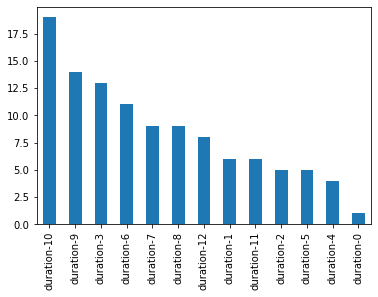

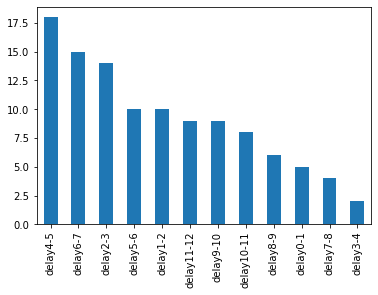

In [9]:
#max delay and duration index for each user
import matplotlib.pyplot as plt
max_dur = duration_df.groupby("UserID").max("duration-*").idxmax(axis=1)
max_del = delay_df.groupby("UserID").max("delay*").idxmax(axis=1)

ax_dur = max_dur.value_counts().plot.bar()
plt.show()
ax_del = max_del.value_counts().plot.bar()
plt.show()

In [10]:
#find users' worst performance's iteration
#valuable only if users' iterarations are stored in order
duration_df['increment'] = duration_df.groupby('UserID').cumcount() + 1
delay_df['increment'] = delay_df.groupby('UserID').cumcount() + 1

print("Users' worst iteration duration wise \n",\
    duration_df.groupby("UserID").max("duration-*").increment)
print("Users' worst iteration pressing wise \n",\
    delay_df.groupby("UserID").max("delay*").increment)

Users' worst iteration duration wise 
 UserID
1      7
2      6
3      6
4      7
5      7
      ..
106    7
107    7
108    7
109    7
110    6
Name: increment, Length: 110, dtype: int64
Users' worst iteration pressing wise 
 UserID
1      7
2      6
3      6
4      7
5      7
      ..
106    7
107    7
108    7
109    7
110    6
Name: increment, Length: 110, dtype: int64


In [11]:
#check mean per iteration
print(duration_df.groupby("increment").mean("duration-*").mean(axis=1)\
,delay_df.groupby("increment").mean("delay*").mean(axis=1))
#-->start kind off slow, then find some rythm but eventually get tired

increment
1    87.193506
2    86.298701
3    85.801299
4    86.292208
5    88.166883
6    87.342208
7    88.255556
dtype: float64 increment
1    197.353846
2    190.278322
3    195.582517
4    194.888811
5    199.542657
6    201.339860
7    198.769231
dtype: float64


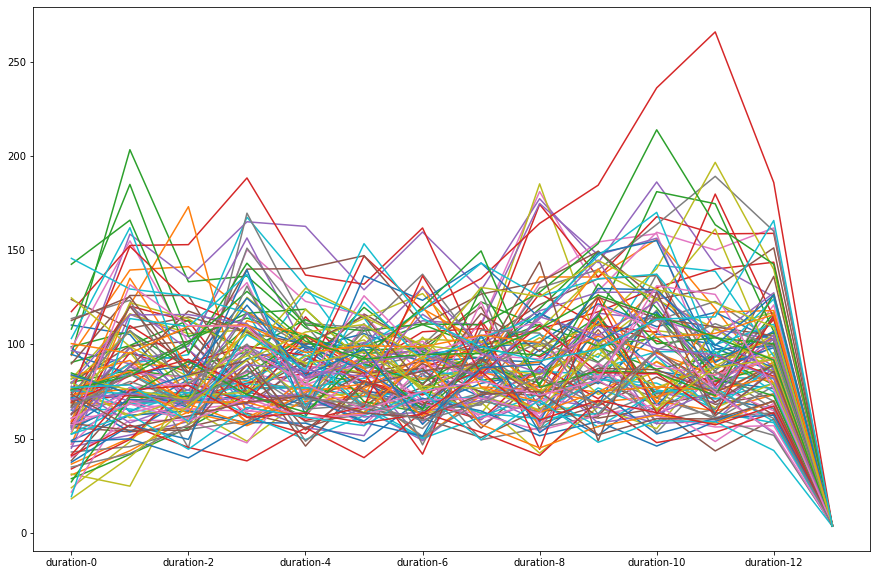

<AxesSubplot:>

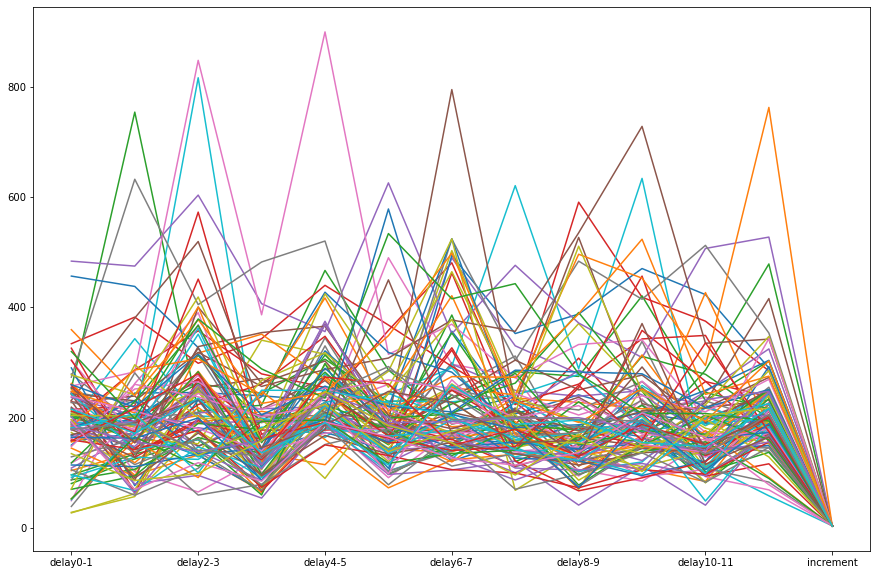

In [12]:
duration_df.groupby("UserID").mean("duration-*").T.plot.line(legend=False\
    ,figsize=(15,10))
plt.show()
delay_df.groupby("UserID").mean("delay*").T.plot.line(legend=False\
    ,figsize=(15,10))

/tmp/ipykernel_29434/1472839415.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dur_df_incr["UserID"] = dur_df_incr["UserID"].astype(str)


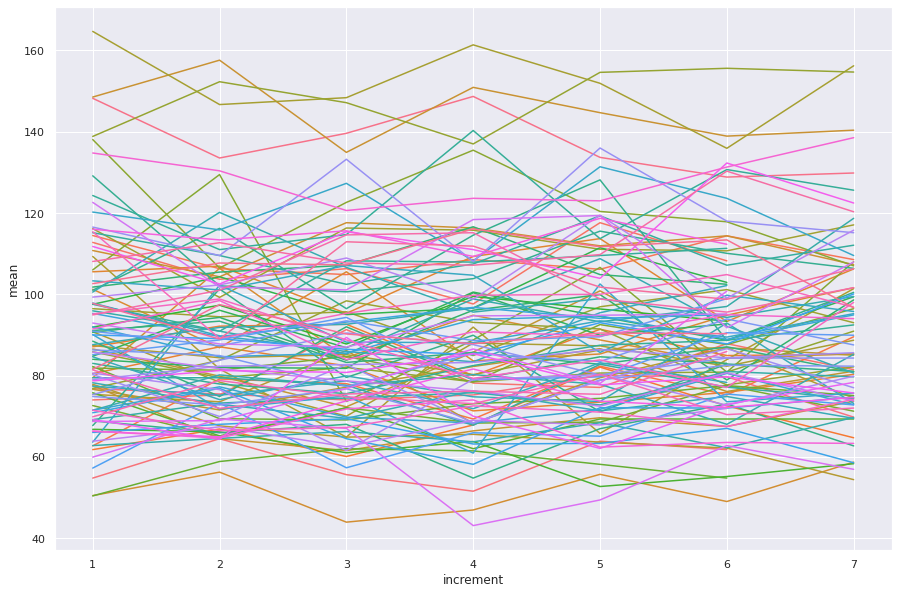

/tmp/ipykernel_29434/1472839415.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_df_incr["UserID"] = del_df_incr["UserID"].astype(str)


<AxesSubplot:xlabel='increment', ylabel='mean'>

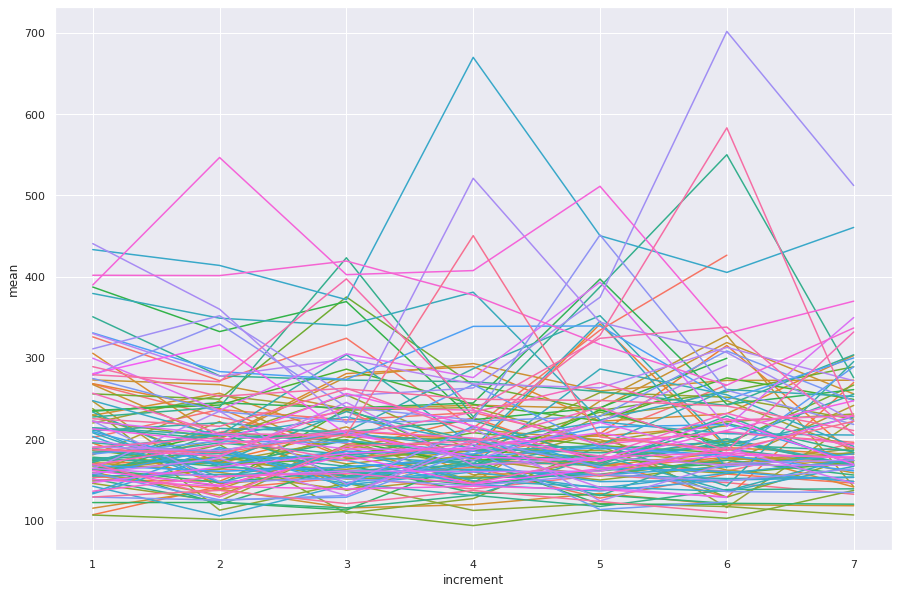

In [13]:
#check how each user performs over time (their mean of duration/delay over all letters)
import seaborn as sns

duration_df["mean"] = duration_df.loc[:,[c for c in \
    duration_df.columns if c!= "UserID" and c!="increment"]].mean(axis=1)
dur_df_incr = duration_df[["UserID","increment","mean"]]
dur_df_incr["UserID"] = dur_df_incr["UserID"].astype(str)
sns.set(rc = {'figure.figsize':(15,10)})
sns.lineplot(data=dur_df_incr,x="increment", y="mean",hue="UserID", legend=False)
plt.show()

delay_df["mean"] = delay_df.loc[:,[c for c in \
    delay_df.columns if c!= "UserID" and c!="increment"]].mean(axis=1)
del_df_incr = delay_df[["UserID","increment","mean"]]
del_df_incr["UserID"] = del_df_incr["UserID"].astype(str)
sns.set(rc = {'figure.figsize':(15,10)})
sns.lineplot(data=del_df_incr,x="increment", y="mean",hue="UserID", legend=False)

#we can spot different behaviors by user (some have more steady performance while others' preformance fluctuates a lot)

### Some statistics

In [14]:
print(duration_df.describe(),"\n", delay_df.describe())

       duration-0  duration-1  duration-2  duration-3  duration-4  duration-5  \
count  750.000000  750.000000  750.000000  750.000000  750.000000  750.000000   
mean    69.169333   88.725333   82.494667   93.672000   85.676000   87.914667   
std     36.846767   39.717249   30.765739   36.897782   30.150673   29.993825   
min      0.000000    0.000000    0.000000    1.000000    1.000000    1.000000   
25%     49.000000   68.000000   67.000000   71.000000   68.000000   69.250000   
50%     72.000000   82.500000   76.000000   90.500000   83.000000   87.000000   
75%     93.750000  104.750000   97.000000  116.000000  100.750000  104.000000   
max    241.000000  289.000000  216.000000  220.000000  273.000000  215.000000   

       duration-6  duration-7  duration-8  duration-9  duration-10  \
count  750.000000   750.00000  750.000000  750.000000   750.000000   
mean    85.746667    89.38800   90.744000   98.784000   101.193333   
std     30.877938    29.76692   39.189806   37.014972    43.

## Feature Engineering

In [15]:
for i in range(13):
    train_df["duration-"+str(i)] = train_df["release-"+str(i)]-train_df["press-"+str(i)]
for i in range(12):
    train_df["delay"+str(i)+"-"+str(i+1)] = train_df["press-"+str(i+1)]-train_df["press-"+str(i)]
for i in range(12):
    train_df["overlap: press"+str(i+1)+"-"+"release"+str(i)] = train_df["press-"+str(i+1)]-train_df["release-"+str(i)]

train_df["mean_rel"] = train_df[[col for col in train_df.columns \
    if col.startswith('release')]].mean(axis=1)
train_df["mean_press"] = train_df[[col for col in train_df.columns \
    if col.startswith('press')]].mean(axis=1)
train_df["mean_dur"] = train_df[[col for col in train_df.columns \
    if col.startswith('duration')]].mean(axis=1)    
train_df["mean_del"] = train_df[[col for col in train_df.columns \
    if col.startswith('delay')]].mean(axis=1)
train_df["mean_overlap"] = train_df[[col for col in train_df.columns \
    if col.startswith('overlap')]].mean(axis=1)

train_df["std_rel"] = train_df[[col for col in train_df.columns \
    if col.startswith('release')]].std(axis=1)
train_df["std_press"] = train_df[[col for col in train_df.columns \
    if col.startswith('press')]].std(axis=1)
train_df["std_dur"] = train_df[[col for col in train_df.columns \
    if col.startswith('duration')]].std(axis=1)    
train_df["std_del"] = train_df[[col for col in train_df.columns \
    if col.startswith('delay')]].std(axis=1)
train_df["std_overlap"] = train_df[[col for col in train_df.columns \
    if col.startswith('overlap')]].std(axis=1)

train_df["total_dur"] = train_df[[col for col in train_df.columns \
    if col.startswith('duration')]].sum(axis=1)
train_df["total_del"] = train_df[[col for col in train_df.columns \
    if col.startswith('delay')]].sum(axis=1)
train_df["del-dur"] = train_df["total_del"] - train_df["total_dur"]  

train_df["max_dur"] = train_df[[col for col in train_df.columns \
    if col.startswith('duration')]].max(axis=1)
train_df["max_del"] = train_df[[col for col in train_df.columns \
    if col.startswith('delay')]].max(axis=1)
train_df["max_del-dur"] = train_df["max_del"] - train_df["max_dur"]    


In [16]:
initial_cols = ['press-0', 'release-0', 'press-1', 'release-1', 'press-2', 'release-2',
       'press-3', 'release-3', 'press-4', 'release-4', 'press-5', 'release-5',
       'press-6', 'release-6', 'press-7', 'release-7', 'press-8', 'release-8',
       'press-9', 'release-9', 'press-10', 'release-10', 'press-11',
       'release-11', 'press-12', 'release-12']
train_df.drop(initial_cols, axis=1, inplace=True)

In [17]:
print(train_df.columns)
train_df.head()

Index(['UserID', 'duration-0', 'duration-1', 'duration-2', 'duration-3',
       'duration-4', 'duration-5', 'duration-6', 'duration-7', 'duration-8',
       'duration-9', 'duration-10', 'duration-11', 'duration-12', 'delay0-1',
       'delay1-2', 'delay2-3', 'delay3-4', 'delay4-5', 'delay5-6', 'delay6-7',
       'delay7-8', 'delay8-9', 'delay9-10', 'delay10-11', 'delay11-12',
       'overlap: press1-release0', 'overlap: press2-release1',
       'overlap: press3-release2', 'overlap: press4-release3',
       'overlap: press5-release4', 'overlap: press6-release5',
       'overlap: press7-release6', 'overlap: press8-release7',
       'overlap: press9-release8', 'overlap: press10-release9',
       'overlap: press11-release10', 'overlap: press12-release11', 'mean_rel',
       'mean_press', 'mean_dur', 'mean_del', 'mean_overlap', 'std_rel',
       'std_press', 'std_dur', 'std_del', 'std_overlap', 'total_dur',
       'total_del', 'del-dur', 'max_dur', 'max_del', 'max_del-dur'],
      dtype='ob

,UserID,duration-0,duration-1,duration-2,duration-3,duration-4,duration-5,duration-6,duration-7,duration-8,...,std_press,std_dur,std_del,std_overlap,total_dur,total_del,del-dur,max_dur,max_del,max_del-dur
0,73,166,185,96,149,88,114,119,100,133,...,644.779102,44.613439,65.107545,91.434030,1927,1831,-96,229,300,71
1,32,72,74,102,72,67,73,88,79,34,...,695.331594,17.612277,46.294430,38.608662,998,2185,1187,107,233,126
2,61,31,69,72,40,80,73,72,48,40,...,1108.604441,16.047605,221.774660,219.963409,712,3216,2504,80,881,801
3,77,1,44,55,87,87,102,69,98,95,...,827.552872,28.035692,73.611799,53.167189,962,2426,1464,102,274,172
4,24,71,94,97,120,103,98,67,115,129,...,1221.868960,29.625872,387.021131,393.779818,1466,3911,2445,176,1517,1341


## Models

In [18]:
import numpy as np
from packaging import version
import sklearn
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

#NO PIPELINE: no scaler, imputer (for null values) necessary, no categorical data  

In [19]:
features = train_df.loc[:, train_df.columns != 'UserID']
target = train_df["UserID"].values
target = target.astype(int) 

In [20]:
models=[svm.SVC(kernel='linear',random_state=1),RandomForestClassifier(random_state=1)]
scores=[]
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
shuf=ShuffleSplit(n_splits=5, random_state=1)
for m in models:
    res=m.fit(features,target)
    scores2=cross_validate(res,features,target,scoring='accuracy',cv=kfold) #cv=shuf is also a choice
    f_s2=scores2['test_score'].mean()
    scores.append(f_s2)
scores=np.array(scores)
scores
#svm needs normalization, tuning and appropriate kernel, here "linear" fits best after a fast/small experimentation 
#because of the structure of the data but still random forest perform better


array([0.58      , 0.73733333])

/home/antman/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


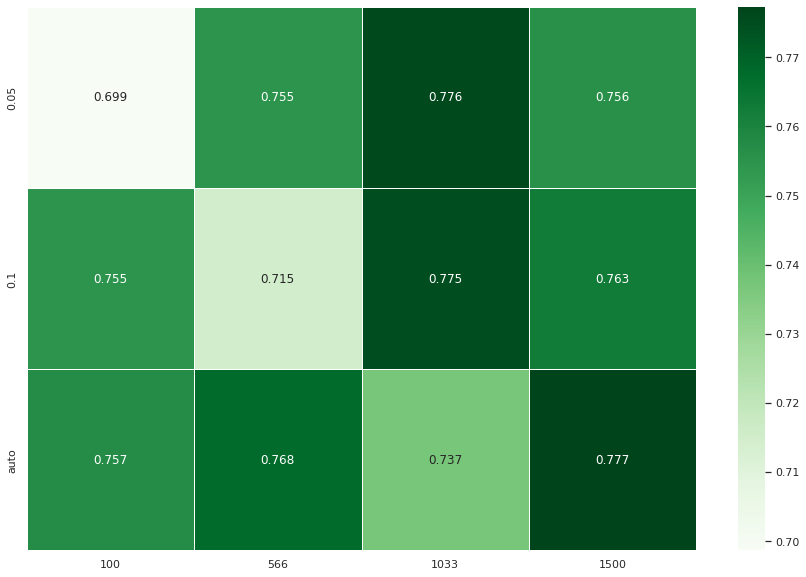

In [21]:
#TUNING RF
from sklearn.model_selection import GridSearchCV 

modelo = RandomForestClassifier(random_state=1)
estim=list(np.linspace(100,1500,4).astype(int)) #trees
max_f=[0.05,0.1,'auto'] #features

params= {'n_estimators':estim , 'max_features':max_f}
res=GridSearchCV(modelo, param_grid=params,cv=kfold,scoring='accuracy', \
    n_jobs=-1).fit(features, target)
scores = res.cv_results_['mean_test_score'].reshape(len(params['n_estimators']),\
                                len(params['max_features'])).T



def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of shape (#rows, #columns) of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")
heatmap(params['n_estimators'], params['max_features'], scores)


In [22]:
#TUNING RF with Randomized search
from sklearn.model_selection import RandomizedSearchCV 

modelo = RandomForestClassifier(random_state=1)
estim=list(np.linspace(100,1500,4).astype(int)) #trees
max_f=[0.05,0.1,'auto'] #features

params= {'n_estimators':estim , 'max_features':max_f}
res=RandomizedSearchCV(modelo, param_distributions=params,cv=kfold,scoring='accuracy', \
    n_jobs=-1).fit(features, target)
res.best_params_
#n_estimatprs: 1500, max_features: 0.1

# %%
#TUNED RF (random)
rf_rand = RandomForestClassifier(n_estimators=1500, max_features= 0.1,random_state=1)
rf_rand.fit(features,target)
scores_rand=cross_validate(rf_rand,features,target,scoring='accuracy',cv=kfold) #cv=shuf is also a choice
f_rand=scores_rand['test_score'].mean()
# %%
f_rand

/home/antman/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.7746666666666666

In [23]:
final_model = RandomForestClassifier(n_estimators=1500, max_features= 'auto',random_state=1)
final_model.fit(features, target)

RandomForestClassifier(n_estimators=1500, random_state=1)

In [24]:
test_df = pd.read_csv('Test_Keystroke.csv')
test_df.head()

,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,0,71,192,287,359,431,616,687,831,903,...,1519,1591,1735,1809,1968,2039,2135,2209,2376,2447
1,0,53,168,240,408,485,622,664,713,792,...,1353,1400,1457,1496,1688,1760,1786,1856,1986,2088
2,0,72,58,136,232,312,337,428,512,622,...,1192,1291,1377,1459,1532,1740,1741,1807,1927,2066
3,0,82,150,223,244,340,484,567,621,692,...,1356,1444,1453,1573,1573,1644,1813,1864,1976,2068
4,0,86,165,268,291,364,464,621,532,622,...,1204,1292,1268,1389,1486,1607,1742,1854,2454,2532


### Same feature engineering as in training dataset

In [25]:
for i in range(13):
    test_df["duration-"+str(i)] = test_df["release-"+str(i)]-test_df["press-"+str(i)]
for i in range(12):
    test_df["delay"+str(i)+"-"+str(i+1)] = test_df["press-"+str(i+1)]-test_df["press-"+str(i)]
for i in range(12):
    test_df["overlap: press"+str(i+1)+"-"+"release"+str(i)] = test_df["press-"+str(i+1)]-test_df["release-"+str(i)]

test_df["mean_rel"] = test_df[[col for col in test_df.columns \
    if col.startswith('release')]].mean(axis=1)
test_df["mean_press"] = test_df[[col for col in test_df.columns \
    if col.startswith('press')]].mean(axis=1)
test_df["mean_dur"] = test_df[[col for col in test_df.columns \
    if col.startswith('duration')]].mean(axis=1)    
test_df["mean_del"] = test_df[[col for col in test_df.columns \
    if col.startswith('delay')]].mean(axis=1)
test_df["mean_overlap"] = test_df[[col for col in test_df.columns \
    if col.startswith('overlap')]].mean(axis=1)

test_df["std_rel"] = test_df[[col for col in test_df.columns \
    if col.startswith('release')]].std(axis=1)
test_df["std_press"] = test_df[[col for col in test_df.columns \
    if col.startswith('press')]].std(axis=1)
test_df["std_dur"] = test_df[[col for col in test_df.columns \
    if col.startswith('duration')]].std(axis=1)    
test_df["std_del"] = test_df[[col for col in test_df.columns \
    if col.startswith('delay')]].std(axis=1)
test_df["std_overlap"] = test_df[[col for col in test_df.columns \
    if col.startswith('overlap')]].std(axis=1)

test_df["total_dur"] = test_df[[col for col in test_df.columns \
    if col.startswith('duration')]].sum(axis=1)
test_df["total_del"] = test_df[[col for col in test_df.columns \
    if col.startswith('delay')]].sum(axis=1)
test_df["del-dur"] = test_df["total_del"] - test_df["total_dur"]  

test_df["max_dur"] = test_df[[col for col in test_df.columns \
    if col.startswith('duration')]].max(axis=1)
test_df["max_del"] = test_df[[col for col in test_df.columns \
    if col.startswith('delay')]].max(axis=1)
test_df["max_del-dur"] = test_df["max_del"] - test_df["max_dur"]

initial_cols = ['press-0', 'release-0', 'press-1', 'release-1', 'press-2', 'release-2',
       'press-3', 'release-3', 'press-4', 'release-4', 'press-5', 'release-5',
       'press-6', 'release-6', 'press-7', 'release-7', 'press-8', 'release-8',
       'press-9', 'release-9', 'press-10', 'release-10', 'press-11',
       'release-11', 'press-12', 'release-12']
test_df.drop(initial_cols, axis=1, inplace=True)


In [26]:
print(test_df.columns)
test_df.head()

Index(['duration-0', 'duration-1', 'duration-2', 'duration-3', 'duration-4',
       'duration-5', 'duration-6', 'duration-7', 'duration-8', 'duration-9',
       'duration-10', 'duration-11', 'duration-12', 'delay0-1', 'delay1-2',
       'delay2-3', 'delay3-4', 'delay4-5', 'delay5-6', 'delay6-7', 'delay7-8',
       'delay8-9', 'delay9-10', 'delay10-11', 'delay11-12',
       'overlap: press1-release0', 'overlap: press2-release1',
       'overlap: press3-release2', 'overlap: press4-release3',
       'overlap: press5-release4', 'overlap: press6-release5',
       'overlap: press7-release6', 'overlap: press8-release7',
       'overlap: press9-release8', 'overlap: press10-release9',
       'overlap: press11-release10', 'overlap: press12-release11', 'mean_rel',
       'mean_press', 'mean_dur', 'mean_del', 'mean_overlap', 'std_rel',
       'std_press', 'std_dur', 'std_del', 'std_overlap', 'total_dur',
       'total_del', 'del-dur', 'max_dur', 'max_del', 'max_del-dur'],
      dtype='object')


,duration-0,duration-1,duration-2,duration-3,duration-4,duration-5,duration-6,duration-7,duration-8,duration-9,...,std_press,std_dur,std_del,std_overlap,total_dur,total_del,del-dur,max_dur,max_del,max_del-dur
0,71,95,72,71,72,71,87,71,72,74,...,758.422215,7.462728,43.442752,46.974768,972,2376,1404,95,257,162
1,53,72,77,42,79,114,47,71,47,39,...,625.944415,22.625434,51.204581,53.382198,885,1986,1101,114,240,126
2,72,78,80,91,110,108,110,92,99,82,...,642.184423,37.247784,58.712641,60.719112,1335,1927,592,208,282,74
3,82,73,96,83,71,70,66,66,88,120,...,649.516289,17.348613,54.012344,60.552694,1029,1976,947,120,240,120
4,86,103,73,157,90,104,43,102,88,121,...,693.127259,27.641709,169.190318,167.989989,1278,2454,1176,157,712,555


In [27]:
preds = final_model.predict(test_df)
preds

array([ 45,  39,  93,  32, 101,  82,  19,  37,  90,  89,  67,  13,  60,
        29,   6,  45,  72,  87,  79, 107, 108,  54,  10,  73,  81,   2,
         3,  65,  61,  18,  68,  55,   8,  20,  25, 106,   5,  74,  54,
         7,  70,  46, 102, 105,  96, 108,  14,  16,  21, 110,  27,  56,
        84,  22,  43,  28,  57,  79, 108,  51,  44,  83,  88, 104,  38,
        71,  23,  83,  52,  91,  61,  15,  41,  88,  62,  31,  52,  80,
       109,  75,  33,  69,  87,  35,  66,  21,  43, 107,  26,  58,  49,
         6,  12,  59,  63,  77,  11,  26, 100,  76,  15,  53,  72, 102,
        35,  91,  53,  17,  86,  44,  92,  75,  99, 110,  99,   3,   4,
         2,  50,  34,  78,  50,  24,  92,  64,  94,  93,  55, 100,   7])

In [28]:
test_df["UserID"] = preds.tolist()
test_df

,duration-0,duration-1,duration-2,duration-3,duration-4,duration-5,duration-6,duration-7,duration-8,duration-9,...,std_dur,std_del,std_overlap,total_dur,total_del,del-dur,max_dur,max_del,max_del-dur,UserID
0,71,95,72,71,72,71,87,71,72,74,...,7.462728,43.442752,46.974768,972,2376,1404,95,257,162,45
1,53,72,77,42,79,114,47,71,47,39,...,22.625434,51.204581,53.382198,885,1986,1101,114,240,126,39
2,72,78,80,91,110,108,110,92,99,82,...,37.247784,58.712641,60.719112,1335,1927,592,208,282,74,93
3,82,73,96,83,71,70,66,66,88,120,...,17.348613,54.012344,60.552694,1029,1976,947,120,240,120,32
4,86,103,73,157,90,104,43,102,88,121,...,27.641709,169.190318,167.989989,1278,2454,1176,157,712,555,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,100,72,78,96,32,67,127,149,120,138,...,36.733622,29.821057,28.253184,1232,2199,967,149,239,90,94
126,69,117,132,35,82,121,149,170,88,148,...,38.882631,82.477683,83.218360,1394,1875,481,170,360,190,93
127,60,102,92,120,13,167,74,188,122,59,...,46.552011,34.195959,66.897649,1253,1266,13,188,194,6,55
128,43,72,47,72,35,64,69,97,77,48,...,16.755405,102.714373,101.705569,818,2188,1370,97,457,360,100


In [29]:
test_df.to_csv(r'/home/antman/Projects/ThreatFabric_DataScience_Challenge/final_test_dataset.csv', index = False)


In [30]:
original_test = pd.read_csv('Test_Keystroke.csv')
original_test["UserID"] = preds.tolist()
original_test

,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12,UserID
0,0,71,192,287,359,431,616,687,831,903,...,1591,1735,1809,1968,2039,2135,2209,2376,2447,45
1,0,53,168,240,408,485,622,664,713,792,...,1400,1457,1496,1688,1760,1786,1856,1986,2088,39
2,0,72,58,136,232,312,337,428,512,622,...,1291,1377,1459,1532,1740,1741,1807,1927,2066,93
3,0,82,150,223,244,340,484,567,621,692,...,1444,1453,1573,1573,1644,1813,1864,1976,2068,32
4,0,86,165,268,291,364,464,621,532,622,...,1292,1268,1389,1486,1607,1742,1854,2454,2532,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0,100,207,279,361,439,535,631,743,775,...,1569,1671,1809,1847,1919,2032,2080,2199,2332,94
126,0,69,19,136,243,375,376,411,515,597,...,1107,1179,1327,1539,1619,1723,1798,1875,2003,93
127,0,60,194,296,271,363,376,496,487,500,...,1006,1007,1066,1080,1178,1164,1260,1266,1328,55
128,0,43,145,217,345,392,414,486,662,697,...,1710,1729,1777,1911,1979,1980,2051,2188,2243,100


In [31]:
original_test.to_csv(r'/home/antman/Projects/ThreatFabric_DataScience_Challenge/OriginalTestWithUserID.csv', index = False)
